In [2]:
# standard libary and settings
import os
import sys

import numpy as np
import pandas as pd
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    KFold,
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    LabelEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
)
from sklearn.svm import SVC, SVR
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder, BinaryEncoder, CountEncoder

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    from mlmachine.data import titanic
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasTransformer,
        KFoldEncoder,
        GroupbyImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style

c:\programdata\anaconda3\envs\petersont\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
import mlmachine as mlm
from mlmachine.data import titanic

from mlmachine.features.preprocessing import (
    DataFrameSelector,
    PandasTransformer,
    PandasFeatureUnion,
)

df_train, df_valid = titanic()

mlmachine_titanic = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked","Cabin"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = {"Pclass": [1, 2, 3]},
    is_classification=True,
)

# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Embarked","Cabin"])
    )),
])

mlmachine_titanic.data = impute_pipe.fit_transform(mlmachine_titanic.data)

>>> category label encoding

	0 --> 0
	1 --> 1



In [4]:
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(
            include_mlm_dtypes=["nominal"],
            exclude_columns=["Cabin"]
        ),
        PandasTransformer(OneHotEncoder())
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["ordinal"]),
        PandasTransformer(
            OrdinalEncoder(categories=list(mlmachine_titanic.ordinal_encodings.values()))
        )
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(
            exclude_columns=[i for i in mlmachine_titanic.data.mlm_dtypes["nominal"] if i != "Cabin"]\
            + list(mlmachine_titanic.ordinal_encodings.keys())
        )
    )),
])

mlmachine_titanic.data = encode_pipe.fit_transform(mlmachine_titanic.data)
mlmachine_titanic.update_dtypes()

In [5]:
mlmachine_titanic.data.mlm_dtypes

{'boolean': [],
 'nominal': ['Cabin',
  'Embarked_C',
  'Embarked_Q',
  'Embarked_S',
  'Sex_female',
  'Sex_male'],
 'ordinal': ['Age_binned_5', 'Fare_binned_5', 'Pclass_ordinal_encoded'],
 'continuous': ['Age', 'Fare'],
 'count': ['Parch', 'SibSp'],
 'string': [],
 'date': [],
 'category': ['Age_binned_5',
  'Cabin',
  'Embarked_C',
  'Embarked_Q',
  'Embarked_S',
  'Fare_binned_5',
  'Pclass_ordinal_encoded',
  'Sex_female',
  'Sex_male'],
 'number': ['Age', 'Fare', 'Parch', 'SibSp']}

Feature summary,Feature vs. target summary,Target proportion
Age_binned_5,Count,Proportion
2,267,29.966330
3,189,21.212121
4,188,21.099888
0,164,18.406285
1,83,9.315376
Age_binned_5,Died,Survived
0,85,79
1,59,24
2,177,90


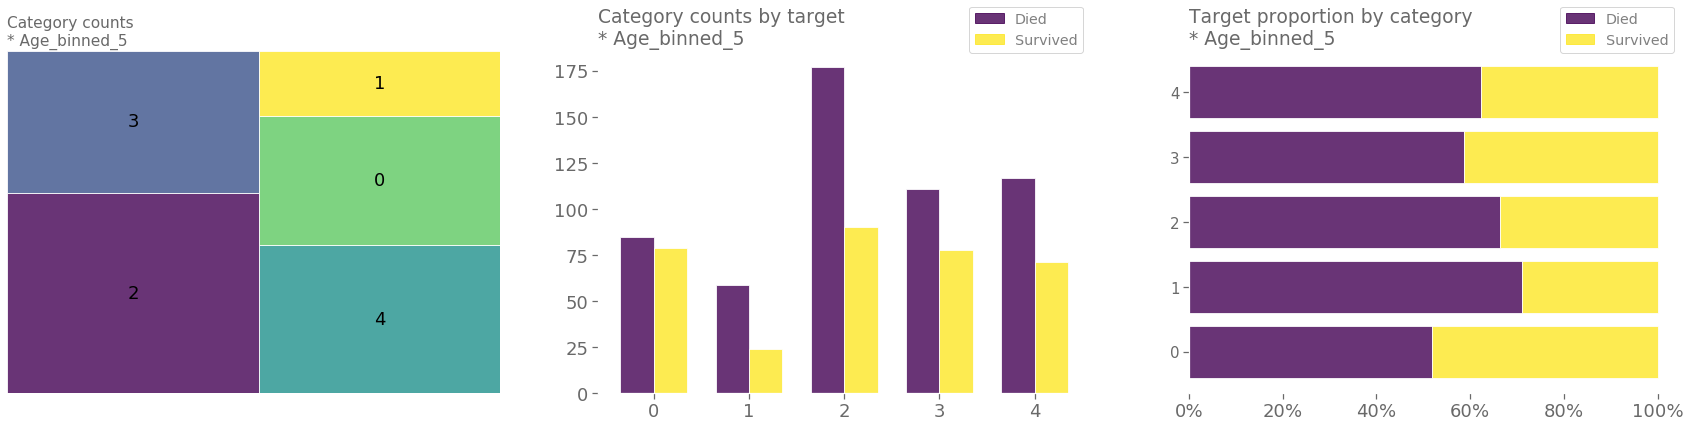

Feature summary,Feature vs. target summary,Target proportion
Fare_binned_5,Count,Proportion
2,195,21.885522
4,182,20.426487
3,175,19.640853
1,173,19.416386
0,166,18.630752
Fare_binned_5,Died,Survived
0,130,36
1,142,31
2,113,82


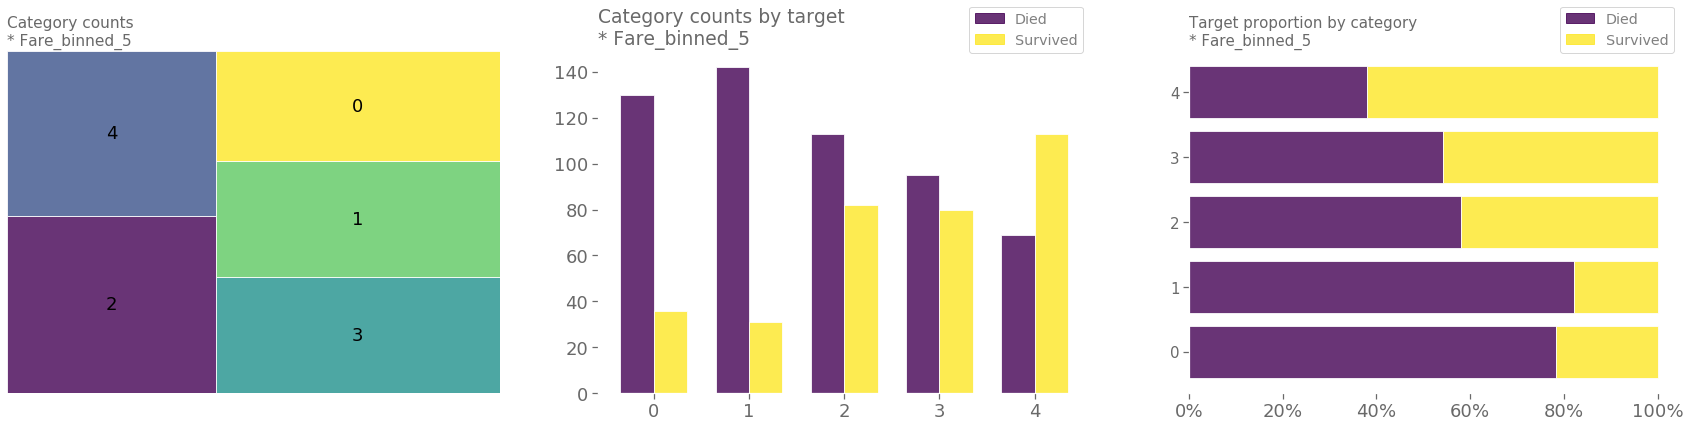

Feature summary Feature vs. target summary Target proportion 
 
 
 Pclass_ordinal_encoded 
 Count 
 Proportion 
 
 
 
 
 2 
 491 
 55.106622 
 
 
 0 
 216 
 24.242424 
 
 
 1 
 184 
 20.650954 
 
 
 
 
 
 Pclass_ordinal_encoded 
 Died 
 Survived 
 
 
 
 
 0 
 80 
 136 
 
 
 1 
 97 
 87 
 
 
 2 
 372 
 119 
 
 
 
 
 
 Class 
 0 
 1 
 2 
 
 
 
 
 Died 
 37.037037 
 52.717391 
 75.763747 
 
 
 Survived 
 62.962963 
 47.282609 
 24.236253

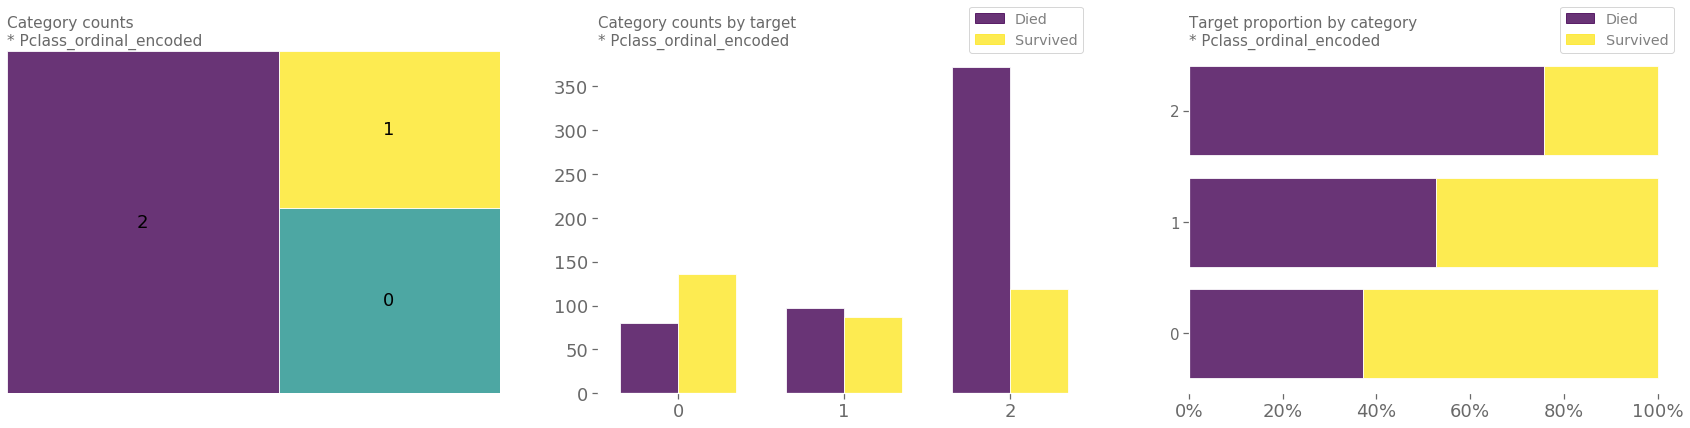

In [6]:
for feature in mlmachine_titanic.data.mlm_dtypes["ordinal"]:
    mlmachine_titanic.eda_cat_target_cat_feat(
        feature=feature,
        legend_labels=["Died","Survived"],
    )